<a href="https://colab.research.google.com/github/wallacecarlis/data_science/blob/main/Projeto_7_Previs%C3%A3o_de_valor_de_im%C3%B3veis_em_S%C3%A3o_Paulo_com_Regress%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

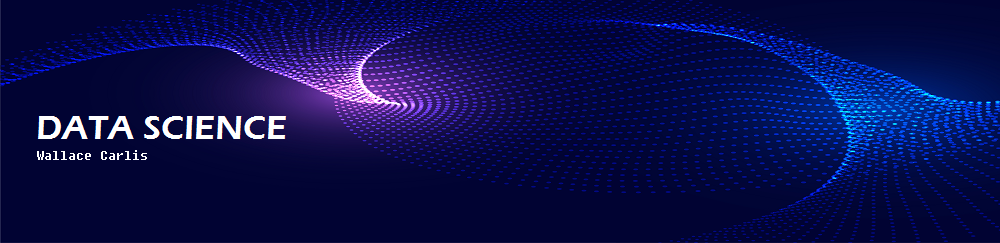

# Previsão de valor de imóveis em São Paulo com Regressão

#### A **aquisição da casa própria** ainda é um sonho para muitos, seja no formato de apartamento, sobrado, ou casa térrea, para ficarmos com alguns exemplos. E, apesar da vivermos atualmente na fase da pandemia do Covid-19, esse mercado não desaqueceu. Isso é nítido em grandes centros, como na cidade de São Paulo. Diversos **fatores** são levados em consideração no momento de aquisição do sonhado imóvel, tanto por quem o busca pela primeira vez, quanto por quem se utiliza do expediente para obter renda à partir de sua locação. Podemos destacar o **tamanho do imóvel**, a **quantidade de quartos**, sua **localização**, se possui **garagem**, se é de fácil acesso ao **transporte público** e ao comércio em geral, enfim, são muitas as combinações.

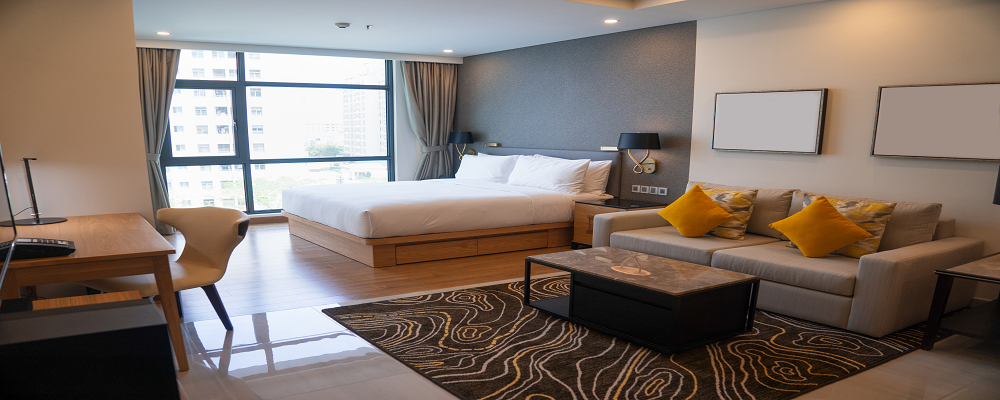

#### Sendo assim, neste projeto iremos utilizar uma base de dados buscando **prever** valores de **compra e locação** de imóveis para a cidade de São Paulo. Como se tratam de valores, utilizaremos modelos de **regressão**. Além disso, disponibilizaremos após o **treinamento** do modelo escolhido, um **link** para uma **aplicação web** que visa realizar uma pesquisa que retornará o **valor previsto** tanto para **compra** quanto para **locação** do imóvel, cujas características serão **escolhidas** pelo usuário.

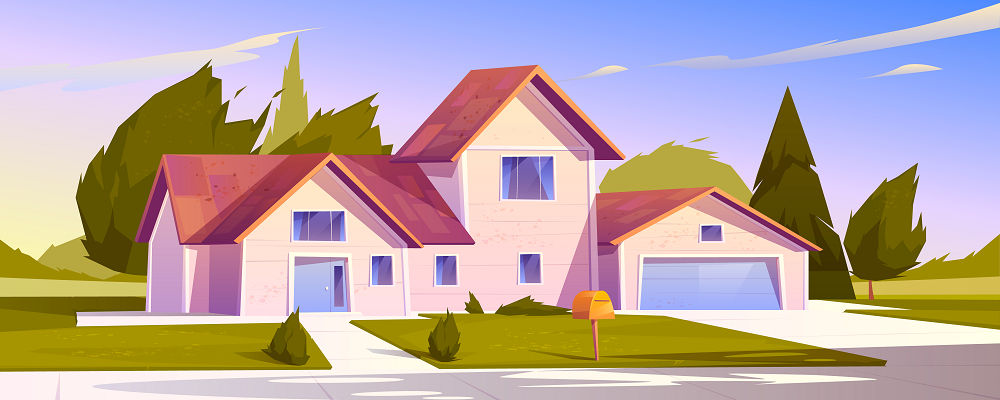

#### Obtendo os dados

#### Os dados utilizados que podem ser obtidos [neste link](https://raw.githubusercontent.com/wallacecarlis/arquivos/main/sao-paulo-properties-april-2019.csv) foram disponibilizados publicamente pela startup **OpenImob**. É uma base que contém cerca de **13 mil** imóveis para **compra e locação**, e seu conteúdo remonta a abril de 2019. O objetivo, mencionado acima, é a **previsão dos valores de compra e locação**.

#### Iniciaremos importando **bibliotecas, pacotes e classes** necessários para **análise e visualização dos dados**, divisão da base em **treino e teste**, construção do modelo de **machine learning**. Num segundo momento, será criada uma **aplicação web** que de fato irá **prever** os valores mediante a combinação dos atributos desejados.

In [ ]:
# Importando bibliotecas, pacotes e classes:

# Análise
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Padronização
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Treino e teste
from sklearn.model_selection import train_test_split

# Regressores
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import linear_model

# Métricas
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Otimização dos hiperparâmetros
from sklearn.model_selection import GridSearchCV

# Salvamento do modelo treinado
from joblib import dump, load
import sklearn

# Tratamento de warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Após a importação dos pacotes vamos atribuir a base de dados que está no formato **csv** à uma variável (**df**).

In [ ]:
# Atribuindo o arquivo:
df = pd.read_csv("https://raw.githubusercontent.com/wallacecarlis/arquivos/main/sao-paulo-properties-april-2019.csv")

#### Como boa prática iremos verificar a quantidade de linhas e colunas da base de dados, bem como elaborar um **dicionário** para os nomes das colunas. Além disso, veremos os tipos de dados e se existem valores ausentes. Faremos isso com as propriedades **shape** e **columns**, e a função **info()**, respectivamente.

In [ ]:
# Visualizando a quantidade de linhas e colunas:
df.shape

(13640, 16)

In [ ]:
# Visualizando os nomes das colunas:
df.columns

Index(['Price', 'Condo', 'Size', 'Rooms', 'Toilets', 'Suites', 'Parking',
       'Elevator', 'Furnished', 'Swimming Pool', 'New', 'District',
       'Negotiation Type', 'Property Type', 'Latitude', 'Longitude'],
      dtype='object')

#### Dicionário de dados:
* **Price** - variável alvo, valor do imóvel;
* **Condo** - valor do condomínio;
* **Size** - tamanho do imóvel em m²;
* **Rooms** - quantidade de quartos;
* **Toilets** - quantidade de banheiros;
* **Suites** - quantidade de suítes;
* **Parking** -  se o imóvel possui estacionamento;
* **Elevator** - se o imóvel possui elevador;
* **Furnished** - se o imóvel vem mobiliado;
* **Swimming Pool** - se o imóvel possui piscina
* **New** - se o imóvel é novo;
* **District** - qual o bairro do imóvel;
* **Negotiation Type** - se o imóvel está à venda ou locação;
* **Property Type** - tipo de imóvel, no caso, apartamento;
* **Latitude** - localização pela latitude;
* **Longitude** - localização pela longitude.

In [ ]:
# Verificando os tipos de dados e nomes de cada coluna, e se existem valores nulos:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             13640 non-null  int64  
 1   Condo             13640 non-null  int64  
 2   Size              13640 non-null  int64  
 3   Rooms             13640 non-null  int64  
 4   Toilets           13640 non-null  int64  
 5   Suites            13640 non-null  int64  
 6   Parking           13640 non-null  int64  
 7   Elevator          13640 non-null  int64  
 8   Furnished         13640 non-null  int64  
 9   Swimming Pool     13640 non-null  int64  
 10  New               13640 non-null  int64  
 11  District          13640 non-null  object 
 12  Negotiation Type  13640 non-null  object 
 13  Property Type     13640 non-null  object 
 14  Latitude          13640 non-null  float64
 15  Longitude         13640 non-null  float64
dtypes: float64(2), int64(11), object(3)
memo

#### Percebemos acima que temos **3 colunas** com dados **categóricos** e as demais com dados **numéricos**. Aparentemente não temos **valores ausentes**. Podemos ainda melhorar nossa compreensão sobre a base de dados visualizando as primeiras e últimas linhas. Utilizaremos, respectivamente, as funções **head()** e **tail()**.

In [ ]:
# Visualização das primeiras linhas:
df.head(2)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718


In [ ]:
# Visualização das últimas linhas:
df.tail(2)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
13638,345000,48,39,1,2,1,1,0,1,1,0,Jabaquara/São Paulo,sale,apartment,-23.652060,-46.637046
13639,161987,0,44,2,1,0,1,0,0,0,0,Jardim Ângela/São Paulo,sale,apartment,-23.613391,-46.523109


#### Informações relevantes:

* A coluna **District** contém tanto o nome do **bairro** quanto o nome da **cidade**. Podemos simplificar a visualização deixando apenas o nome do **bairro**. Utilizaremos as funções **apply() e lambda**.
* As outras colunas **categóricas** são: o **tipo de negociação**, ou seja, se é **venda (compra) ou aluguel**, e o **tipo da propriedade**. Podemos utilizar a função **unique()** para verificar quais são de fato os valores únicos das colunas.
* As demais colunas são numéricas, sendo do tipo **int** ou **float**. Utilizaremos a **padronização** para a criação dos nossos modelos de **machine learning**.

#### Para iniciarmos o processo de tratamento vale como boa prática gerar uma cópia da base de dados. Utilizaremos a função **copy()**.

In [ ]:
# Gerando uma cópia da base de dados:
df_clean = df.copy()

In [ ]:
# Confirmando a inexistência de valores ausentes:
df_clean.isnull().values.any()

False

In [ ]:
# Tratando a coluna "District" para permanecer somente os nomes do bairros:
df_clean.District = df_clean.District.apply(lambda x: x.split('/')[0])

In [ ]:
# Visualizando o tratamento realizado na coluna "District":
df_clean.District.head(1)

0    Artur Alvim
Name: District, dtype: object

In [ ]:
# Visualizando os nomes dos bairros:
df_clean.District.unique()

array(['Artur Alvim', 'Belém', 'Cangaíba', 'Carrão', 'Cidade Líder',
       'Cidade Tiradentes', 'Ermelino Matarazzo', 'Iguatemi',
       'Itaim Paulista', 'Itaquera', 'Jardim Helena', 'José Bonifácio',
       'Lajeado', 'Parque do Carmo', 'Penha', 'Ponte Rasa', 'Sapopemba',
       'São Lucas', 'São Mateus', 'São Miguel', 'São Rafael', 'Tatuapé',
       'Vila Curuçá', 'Vila Formosa', 'Vila Jacuí', 'Vila Matilde',
       'Vila Prudente', 'Cambuci', 'Campo Belo', 'Campo Grande',
       'Campo Limpo', 'Capão Redondo', 'Cidade Ademar', 'Cidade Dutra',
       'Cursino', 'Grajaú', 'Ipiranga', 'Itaim Bibi', 'Jabaquara',
       'Jardim Ângela', 'Jardim Paulista', 'Moema', 'Morumbi', 'Pedreira',
       'Sacomã', 'Santo Amaro', 'Saúde', 'Socorro', 'Vila Andrade',
       'Vila Mariana', 'Vila Sônia', 'Alto de Pinheiros', 'Anhanguera',
       'Brasilândia', 'Butantã', 'Cachoeirinha', 'Freguesia do Ó',
       'Jaguaré', 'Jaraguá', 'Lapa', 'Limão', 'Perdizes', 'Pinheiros',
       'Pirituba', 'Raposo

In [ ]:
# Verificando as "10 maiores quantidades" de imóveis por bairro:
df_clean.groupby(["District"]).size().sort_values(ascending = False)[:10]

District
Moema                293
Mooca                288
Brás                 255
Bela Vista           250
Brooklin             250
Pinheiros            249
Casa Verde           248
Cambuci              241
Perdizes             236
Alto de Pinheiros    230
dtype: int64

In [ ]:
# Visualização dos valores únicos da coluna "Negotiation Type": 
np.unique(df_clean["Negotiation Type"], return_counts=True)

(array(['rent', 'sale'], dtype=object), array([7228, 6412]))

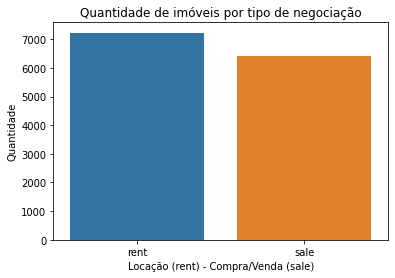

In [ ]:
# Visualização da quantidade de imóveis disponíveis por "compra/venda" e "locação":
fig, ax = plt.subplots()
sns.countplot("Negotiation Type", data=df_clean, ax = ax)
ax.set_title("Quantidade de imóveis por tipo de negociação")
ax.set_xlabel("Locação (rent) - Compra/Venda (sale)")
ax.set_ylabel("Quantidade")
plt.show()

In [ ]:
# Visualização dos valores únicos da coluna "Property Type":
df_clean["Property Type"].unique()

array(['apartment'], dtype=object)

#### Uma vez que realizamos os tratamentos acima podemos verificar o **resumo estatístico** das colunas **numéricas** com a função **describe()** para analisar se precisaremos realizar novos tratamentos.

In [ ]:
# Verificando o resumo estatístico:
round(df_clean.describe())

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,Latitude,Longitude
count,13640.0,13640.0,13640.0,13640.0,13640.0,13640.0,13640.0,13640.0,13640.0,13640.0,13640.0,13640.0,13640.0
mean,287738.0,690.0,84.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,-22.0,-44.0
std,590821.0,758.0,58.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,6.0,11.0
min,480.0,0.0,30.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-47.0,-58.0
25%,1859.0,290.0,50.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,-24.0,-47.0
50%,8100.0,500.0,65.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,-24.0,-47.0
75%,360000.0,835.0,94.0,3.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,-24.0,-47.0
max,10000000.0,9500.0,880.0,10.0,8.0,6.0,9.0,1.0,1.0,1.0,1.0,0.0,0.0


#### Ao levarmos em consideração os valores **máximo**, **médio**, **mediano** e **desvio padrão** podemos perceber que podem existir **outliers**. Por exemplo, se para a coluna **Price** a **média** orbita em cerca de **287 mil** e o **terceiro quartil (75%)** ao redor de **360 mil**, o valor máximo aparecendo em **10 milhões** é de fato distante. Outra coluna que pode nos ajudar na percepção é a **Size**, onde o tamanho médio é cerca de **84(m²)**, e o tamanho máximo quase **10x** maior (**880m²**).

#### Contudo, apesar das duas colunas **(Prize e Size)** nos darem tais observações, utilizaremos apenas a **Size** para análise dos **outliers**, uma vez que a coluna **Price** ficará muito sensível por possuir valores distantes entre si, como os de **compra** e **locação**. Optaremos por tratar o **tamanho** dos imóveis em detrimento ao **preço**.

#### Aplicaremos a fórmula dos **quartis** para obtermos valores mais assertivos para a coluna **Size**.

In [ ]:
# Aplicando a fórmula dos quartis e identificando os outliers para a coluna "Size":
q1_size = df_clean.Size.quantile(.25)
q3_size = df_clean.Size.quantile(.75)
IQR_size = q3_size - q1_size
print('IQR da variável Size: ', IQR_size)

# Definindo os limites                                       
sup_size = q3_size + 1.5 * IQR_size
inf_size = q1_size - 1.5 * IQR_size

print('Limite superior de size: ', sup_size)
print('Limite inferior de size: ', inf_size)

IQR da variável Size:  44.0
Limite superior de size:  160.0
Limite inferior de size:  -16.0


#### Após a verificação acima pudemos observar que a **fórmula dos quartis** nos traz o limite superior em **160**. Ou seja, definiremos que uma casa com **160m²** será nosso maior valor disponível em tamanho. A fórmula traz também o limite inferior, contudo, não existe imóvel com metragem **negativa (-16m²)**. Caberá, portanto, nova verificação da função **describe()** mais a frente.

#### Podemos gerar um **boxplot** e um **distplot** para a assertividade da visualização gráfica da coluna **Size** sobre seu resumo estatístico atual.

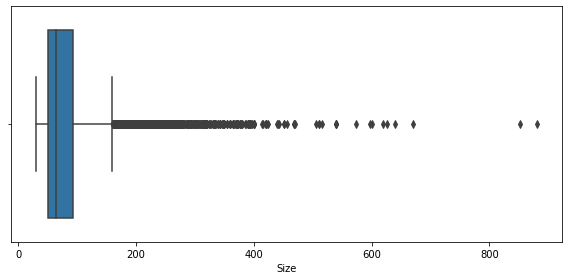

In [ ]:
# Visualizando os valores estatísticos da coluna "Size":
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(df_clean['Size'], ax=ax)
plt.tight_layout()

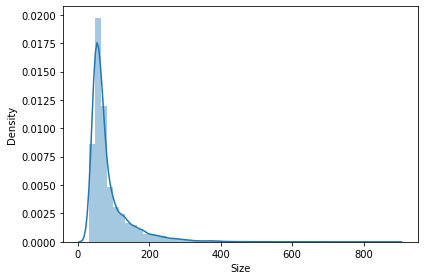

In [ ]:
# Visualizando a distribuição da coluna "Size":
fig, ax = plt.subplots()
sns.distplot(df_clean.Size, hist=True, ax = ax)
plt.tight_layout()

#### Como esperado os maiores imóveis em tamanho na base de dados interferem negativamente, tanto na compreensão do **boxplot** quanto no gráfico de **distribuição**. Realizaremos os tratamentos dos valores passando como limite a metragem de **160m²**.

In [ ]:
# Tratando valores superiores a "160" na coluna "Size":
df_clean.drop(df_clean[df_clean.Size > 160].index, axis=0, inplace=True)

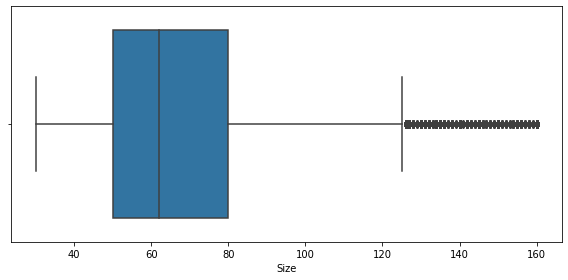

In [ ]:
# Visualizando o boxplot da coluna "Size" após o tratamento:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(df_clean['Size'], ax=ax)
plt.tight_layout()

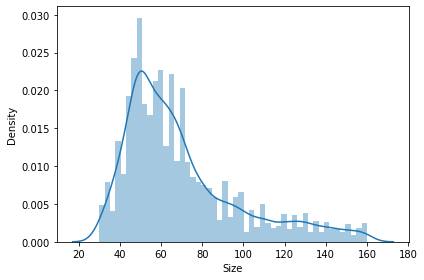

In [ ]:
# Visualização da distribuição da coluna "Size" após o tratamento:
fig, ax = plt.subplots()
sns.distplot(df_clean.Size, hist=True, ax = ax)
plt.tight_layout()

In [ ]:
# Verificação do resumo estatístico das colunas "Size":
round(df_clean["Size"].describe(), 2)

count    12402.00
mean        69.64
std         28.22
min         30.00
25%         50.00
50%         62.00
75%         80.00
max        160.00
Name: Size, dtype: float64

#### Nitidamente os valores de **média (69m²) e mediana (62m²)** se aproximaram após o tratamento dos **outliers**. Vale ressaltar que poderíamos, de forma parcial, mediante a visualização dos gráficos acima, termos escolhido o tamanho **máximo** para a coluna **Size** como sendo de **100m²**. Contudo, **160m²** nos satisfaz no momento.

#### Podemos também gerar um **gráfico de dispersão** entre algumas colunas que geralmente apontam para uma **correlação** positiva, como por exemplo, entre os valores de **condomínio e preço do imóvel**. Ou seja, na maioria das vezes que o valor do imóvel aumenta, o valor do condomínio também aumenta.

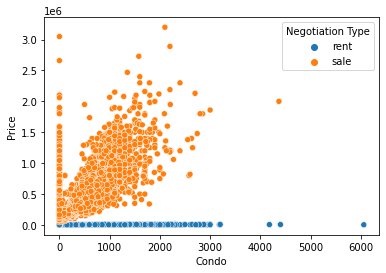

In [ ]:
# Correlacionando os valores de "preço" e "condomínio":
sns.scatterplot(x = 'Condo', y = 'Price', hue = 'Negotiation Type', data = df_clean);

#### A mesma percepção se aplica quando correlacionamos o valor do condomínio ao tamanho do imóvel, seja na compra/venda ou locação. Ou ainda, quando correlacionamos o valor do imóvel à quantidade de suítes.

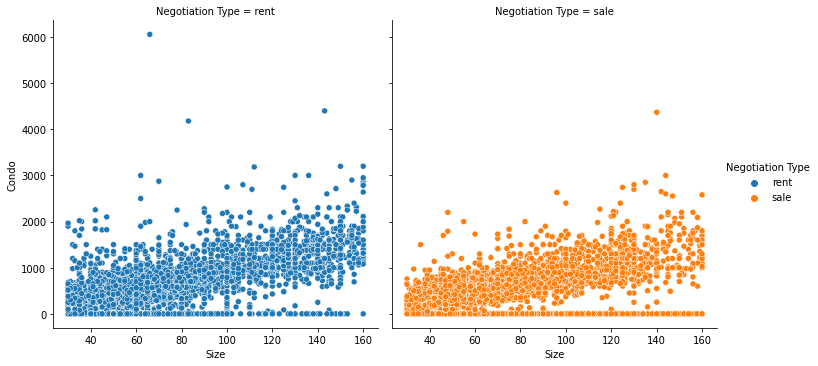

In [ ]:
# Correlacionando os valores de "condomínio" e tamanho do imóvel:
sns.relplot(x = 'Size', y = 'Condo', data = df_clean, hue = 'Negotiation Type', col = 'Negotiation Type');

<Figure size 864x576 with 0 Axes>

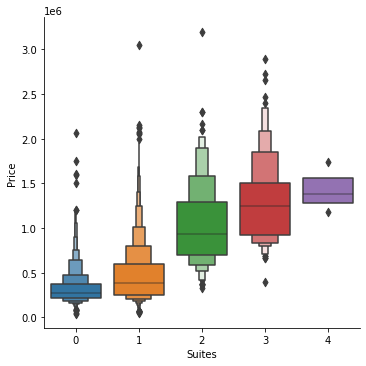

In [ ]:
# Correlacionando os valores do imóvel à quantidade de suítes por "compra/venda":
plt.figure(figsize = (12,8))
ax = sns.catplot(x = 'Suites', y = "Price", data = df_clean[df_clean["Negotiation Type"] == "sale"], kind = "boxen");

#### Numa análise mais assertiva, verificaremos que não precisaremos das colunas **tipo de propriedade**, visto que temos apenas **apartamento** como sua categoria, bem como as localizações de **latitude e longitude**. Caso fôssemos utilizar algum tipo de **mapa**, essas últimas seriam de fato necessárias, mas não é o caso. Iremos, portanto, excluí-las. Contudo, trabalharemos numa nova cópia da base de dados.

In [ ]:
# Gerando uma nova cópia da base de dados tratada:
df_tratado = df_clean.copy()

In [ ]:
# Excluindo as colunas não utilizáveis:
df_tratado.drop(["Property Type", "Latitude", "Longitude"],axis=1, inplace=True)

In [ ]:
# Confirmando as exclusões das colunas:
df_tratado.head(2)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim,rent
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim,rent


#### Uma vez que temos a base de dados com as colunas que iremos de fato trabalhar, precisaremos gerar **dummies** para a coluna **District**, utilizares a função **get_dummies**.

In [ ]:
# Gerando variáveis dummies:
df_tratado = pd.get_dummies(df_tratado)

In [ ]:
# Verificando a nova base de dados:
df_tratado.head(2)

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District_Alto de Pinheiros,District_Anhanguera,District_Aricanduva,District_Artur Alvim,District_Barra Funda,District_Bela Vista,District_Belém,District_Bom Retiro,District_Brasilândia,District_Brooklin,District_Brás,District_Butantã,District_Cachoeirinha,District_Cambuci,District_Campo Belo,District_Campo Grande,District_Campo Limpo,District_Cangaíba,District_Capão Redondo,District_Carrão,District_Casa Verde,District_Cidade Ademar,District_Cidade Dutra,District_Cidade Líder,District_Cidade Tiradentes,District_Consolação,District_Cursino,District_Ermelino Matarazzo,District_Freguesia do Ó,...,District_Perdizes,District_Perus,District_Pinheiros,District_Pirituba,District_Ponte Rasa,District_Raposo Tavares,District_República,District_Rio Pequeno,District_Sacomã,District_Santa Cecília,District_Santana,District_Santo Amaro,District_Sapopemba,District_Saúde,District_Socorro,District_São Domingos,District_São Lucas,District_São Mateus,District_São Miguel,District_São Rafael,District_Sé,District_Tatuapé,District_Tremembé,District_Tucuruvi,District_Vila Andrade,District_Vila Curuçá,District_Vila Formosa,District_Vila Guilherme,District_Vila Jacuí,District_Vila Leopoldina,District_Vila Madalena,District_Vila Maria,District_Vila Mariana,District_Vila Matilde,District_Vila Olimpia,District_Vila Prudente,District_Vila Sônia,District_Água Rasa,Negotiation Type_rent,Negotiation Type_sale
0,930,220,47,2,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1000,148,45,2,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Podemos iniciar a construção do nosso modelo de **machine learning**. Para isso, vamos realizar alguns processos:

* **instanciar** o modelo escolhido;
* **separar** a base em **X** e **y**;
* **dividir** a base em **treino e teste**;
* **padronizar** a base;
* se preciso, realizar a **validação cruzada**;
* realizar a **metrificação**.

#### Iniciaremos com o **Random Forest Regressor**.

In [ ]:
# Gerando um objeto para o "Random Forest Regressor":
model_rfr = RandomForestRegressor()

In [ ]:
# Separando a base em variável alvo e variáveis independentes:
X = df_tratado.drop("Price", axis=1)
y = df_tratado.Price

In [ ]:
# Dividindo a base em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Criando um objeto para padronização dos dados:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

In [ ]:
# Validação Cruzada:
score_rfr = cross_val_score(model_rfr, X_train, y_train, cv=10)

In [ ]:
# Métrica de avaliação da validação cruzada para Random Forest Regressor:
print("Scores: ", score_rfr)
print("\nScore - Random Forest: {:.4f} (+/- {:.2f})".format(score_rfr.mean(), score_rfr.std()))

Scores:  [0.90181036 0.93946317 0.90529115 0.92601995 0.92805991 0.89974117
 0.91609846 0.91341445 0.90949709 0.92528531]

Score - Random Forest: 0.9165 (+/- 0.01)


#### Treino e teste com **Random Forest Regressor**.

In [ ]:
model_rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# Realizando as previsões sobre a base de "teste":
y_pred_rfr = model_rfr.predict(X_test)

#### Verificando os resultados para o **Random Forest Regressor**.

In [ ]:
# Verificando as métricas de avaliação da regressão:
print("r2: \t{:.4f}".format(r2_score(y_test, y_pred_rfr)))
print("MAE: \t{:.4f}".format(mean_absolute_error(y_test, y_pred_rfr)))
print("MSE: \t{:.4f}".format(mean_squared_error(y_test, y_pred_rfr)))

r2: 	-0.4228
MAE: 	261131.4479
MSE: 	172143334417.7020


#### Podemos comparar o resultado do **Random Forest Regressor** com outros regressores, escolhidos de forma parcial, mas observando a própria recomendação do **Scikit Learn Algorithm Cheat-Sheet**, sendo eles **Ridge** e **Linear Regression**.

#### Ridge

In [ ]:

# Gerando um objeto para o "Ridge":
model_rr = linear_model.Ridge(alpha=.5)

# Validação Cruzada:
score_rr = cross_val_score(model_rr, X_train, y_train, cv=10)

# Treino:
model_rr.fit(X_train, y_train)

# Realizando as previsões sobre a base de "teste":
y_pred_rr = model_rr.predict(X_test)

# Métrica de avaliação da validação cruzada para Random Forest Regressor:
print("Scores: ", score_rr)
print("\nScore - Ridge Regressor: {:.4f} (+/- {:.2f})".format(score_rr.mean(), score_rr.std()))

# Verificando as métricas de avaliação da regressão:
print("r2: \t{:.4f}".format(r2_score(y_test, y_pred_rr)))
print("MAE: \t{:.4f}".format(mean_absolute_error(y_test, y_pred_rr)))
print("MSE: \t{:.4f}".format(mean_squared_error(y_test, y_pred_rr)))

Scores:  [0.70803558 0.74156097 0.6878688  0.7029641  0.70186127 0.70493684
 0.69743264 0.72598186 0.69852783 0.73091916]

Score - Ridge Regressor: 0.7100 (+/- 0.02)
r2: 	-339.3212
MAE: 	4562434.9849
MSE: 	41175225608028.0625


#### Linear Regression

In [ ]:
# Gerando um objeto para o "Linear Regression":
model_lir = linear_model.LinearRegression()

# Validação Cruzada:
score_lir = cross_val_score(model_lir, X_train, y_train, cv=10)

# Treino:
model_lir.fit(X_train, y_train)

# Realizando as previsões sobre a base de "teste":
y_pred_lir = model_lir.predict(X_test)

# Métrica de avaliação da validação cruzada para Linear Regression:
print("Scores: ", score_lir)
print("\nScore - Linear Regression: {:.4f} (+/- {:.2f})".format(score_lir.mean(), score_lir.std()))

# Verificando as métricas de avaliação da regressão:
print("r2: \t{:.4f}".format(r2_score(y_test, y_pred_lir)))
print("MAE: \t{:.4f}".format(mean_absolute_error(y_test, y_pred_lir)))
print("MSE: \t{:.4f}".format(mean_squared_error(y_test, y_pred_lir)))

Scores:  [0.70803083 0.74151052 0.68788443 0.70295197 0.70186035 0.70362217
 0.69751617 0.72598028 0.69849625 0.72991497]

Score - Linear Regression: 0.7098 (+/- 0.02)
r2: 	-297254865699750843252736.0000
MAE: 	189613822191166432.0000
MSE: 	35964654738759530594986761220259840.0000


#### Como verificado o modelo **Random Forest Regressor** obteve o melhor resultado para a métrica **R²** com cerca de **0.2** no erro, e de **91,65%** de acerto no **score**. Verificaremos com a **otimização** dos parâmetros se conseguimos melhorar os resultados. A página do **scikit-learn** com os parâmetros do **Random Forest Regressor** pode ser acessada **[aqui](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)**. Para a seleção utilizaremos o **GridSearch()**.

#### Vamos optar por alguns parâmetros para a tentativa de otimização do modelo. Selecionaremos os seguintes propondo alterar os parâmetros **default**:
* criterion "mse";
* n_estimators "100";
* min_samples_split "2";
* min_samples_leaf "1".

In [ ]:
# Selecionando os parâmetros para a tentativa de otimização do modelo:
parametros = {'criterion': ['mse', 'mae'], 'n_estimators': [100, 150], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 5]}

In [ ]:
# Otimizando os melhores parâmetros com "GridSearchCV":
grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parametros)
grid_search.fit(X_train, y_train)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

{'criterion': 'mae', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
0.9185517756000323


#### Após a otimização (cerca de 4h) obtivemos os seguintes resultados com os parâmetros:
* criterion "mae";
* n_estimators "150";
* min_samples_split "5";
* min_samples_leaf "1" (item sem alteração).

#### Comparação entre os resultados:
* com otimização - 91,85%.
* sem otimização - 91,65%.

#### De posse dos melhores parâmetros podemos preparar nosso modelo final.

In [ ]:
# Preparando o modelo final:

# Gerando o objeto para o "Random Forest Regressor":
model_rfr = RandomForestRegressor(criterion= "mae", n_estimators= 150, min_samples_split= 5, min_samples_leaf= 1)

# Validação Cruzada:
score_rfr = cross_val_score(model_rfr, X_train, y_train, cv=10)

# Treino:
model_rfr.fit(X_train, y_train)

# Realizando as previsões sobre a base de "teste":
y_pred_rfr = model_rfr.predict(X_test)

# Métrica de avaliação da validação cruzada para Random Forest Regressor:
print("Scores: ", score_rfr)
print("\nScore - Random Forest Regressor: {:.4f} (+/- {:.2f})".format(score_rfr.mean(), score_rfr.std()))

# Verificando as métricas de avaliação da regressão:
print("r2: \t{:.4f}".format(r2_score(y_test, y_pred_rfr)))
print("MAE: \t{:.4f}".format(mean_absolute_error(y_test, y_pred_rfr)))
print("MSE: \t{:.4f}".format(mean_squared_error(y_test, y_pred_rfr)))
print("RMSE: \t{:.4f}".format(np.sqrt(mean_squared_error(y_test, y_pred_rfr))))

Scores:  [0.90270113 0.94051229 0.90979897 0.92666877 0.92646565 0.90048834
 0.90723319 0.9137613  0.9066604  0.92949623]

Score - Random Forest Regressor: 0.9164 (+/- 0.01)
r2: 	-0.2529
MAE: 	247184.6400
MSE: 	151593428772.3900
RMSE: 	389350.0081


#### Uma vez que temos nosso modelo treinado, podemos salvá-lo com o melhor resultado. Utilizaremos a biblioteca **joblib**. Outra informação importante é mensurar em qual versão do **scikit-learn** o modelo salvo foi treinado.

In [ ]:
# Salvando o modelo em formato "joblib":
dump(model_rfr, 'model.joblib')

['model.joblib']

In [ ]:
# Versão do scikit-learn:
sklearn.__version__

'0.22.2.post1'

#### Concluindo

#### O **primeiro** passo era trabalhar a base de dados para treinar um modelo que tivesse um resultado significativo na previsão de valores de **compra/venda** e/ou **locação** de imóveis para a cidade de **São Paulo**. O **segundo**, a construção da **aplicação web** justamente para a realização da pesquisa de valores.

#### **Base de dados** - Um dataset disponível no **kaggle**. São cerca de **13 mil** registros com **16** colunas. O tratamento mais significativo foi sem dúvida na coluna que continha os nomes dos bairros. Uma vez que precisamos utilizar a função **lambda** para o tratamento, para depois realizar a geração de novas colunas com o **get_dummies**. A ausência de **valores nulos** facilitou o processo, visto que a maioria das colunas trazia valores numéricos. Bem como a correção de **outliers** para a coluna **Size**, trazendo uma compreensão mais assertiva para a maioria das buscas no que se refere ao tamanho do imóvel.

#### **Machine Learning** - A precificação busca uma resolução nos algoritmos de **regressão**. No caso, optei de forma parcial pelos modelos clássicos, como as regressões **Linear** e **Ridge**, bem como a que trouxe o melhor resultado, **Random Forest**. Obviamente, houve ainda tanto o processo de **padronização** dos dados quanto o de **validação cruzada**, bem como a otimização de parâmetros com **GridSearch**. Vale mencionar as **4 horas** de otimização e as **2 horas** de passagem com o **modelo final**.

#### **Resultados** - Quando se trata de **classificação** as métricas ideais são **acurácia**, **recall**, **precisio**, **f1-score** e **curva roc**. Contudo, na **regressão** mensuramos os **erros**, ou seja, o quanto nosso **modelo** erra menos. Por isso, utilizamos os erros **mae(Erro Absoluto Médio)**, **mse(Erro Quadrático Médio)**, **rmse(Raiz do Erro Quadrático Médio)** e **R²(Coeficiente de Determinação, a proporção da variância)**. Vale mencionar que **R²** é extremamente afetado por outliers, e que **rmse** é o erro de performance. Os resultados **com e sem otimização** ficaram bem próximos, na casa de **92%** de acerto, com um **R²** em cerca de **0.2**.

#### **Síntese** - Apesar de alguns dados técnicos trata-se ainda de uma **análise inicial** para tratamento da base de dados com a finalidade da geração de uma **aplicação web** para **previsão** de valores de **compra/venda e locação** de imóveis para a cidade de **São Paulo**. Pode-se ainda trabalhar individualmente os quesitos de **compra/venda e locação**, gerando novos **insights**, explorando particularidades de bairros, quantidades de suítes, banheiros, garagem, piscina, etc. Obviamente, não foi o foco deste projeto. Contudo, o conteúdo pode ser utilizado para expansão do tema.

#### Obs.: podem ocorrer pequenas variações dos resultados nos algoritmos, sem contudo interferir na escolha do modelo final.


#### Muito obrigado pela leitura. Caso tenha interesse em analisar outros projetos fique à vontade acessando diretamente meu **[GitHub](https://github.com/wallacecarlis/data_science)** e **[Medium](https://wallacecarlis.medium.com/)**.